In [1]:
!pip install --upgrade wandb
# !pip install git+https://github.com/qubvel/efficientnet

     |████████████████████████████████| 1.8 MB 3.0 MB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.9.4
    Uninstalling wandb-0.9.4:
      Successfully uninstalled wandb-0.9.4
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Image Data Generator
from keras.preprocessing.image import ImageDataGenerator

# Kaggle dataset
from kaggle_datasets import KaggleDatasets

# Pre-trained
from tensorflow.keras.applications import DenseNet201, Xception

# Keras components
from keras.models import Model, Sequential
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Input, Reshape, Concatenate, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAvgPool2D
from keras.layers import Subtract, Multiply
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical

# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Experiment tracking using Weights and Biases
import wandb
from wandb.keras import WandbCallback

# for error
# https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# TPU setting
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Configuration
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
64


In [5]:
# Get Images path and labels

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path("pre-product-matching-id-ndsc-2020")

def get_images_path_and_labels(df, path, get_label=True):
    image1_paths = []
    image2_paths = []
    labels = []

    image1_paths = df.image_1.apply(lambda x: '{}/{}/{}/{}'.format(GCS_DS_PATH, path, path, x)).tolist()
    image2_paths = df.image_2.apply(lambda x: '{}/{}/{}/{}'.format(GCS_DS_PATH, path, path, x)).tolist()
    
    if get_label:
        labels = df.Label.tolist()
        return image1_paths, image2_paths, labels
    else:
        return image1_paths, image2_paths, [0] * len(image1_paths)

In [6]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Cross-Validation Pipeline

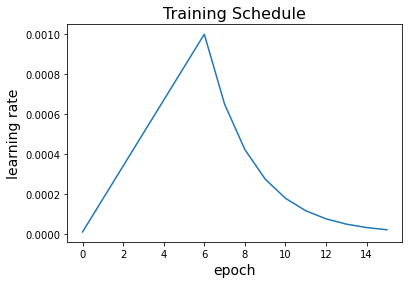

[1e-05, 0.000175, 0.00034, 0.000505, 0.00067, 0.000835, 0.001, 0.0006500000000000001, 0.0004225, 0.000274625, 0.00017850625000000005, 0.00011602906250000002, 7.541889062500001e-05, 4.9022278906250016e-05, 3.186448128906251e-05, 2.0711912837890633e-05]


In [7]:
# Model Parameter
# Configuration
BATCH_SIZE = 10 * strategy.num_replicas_in_sync
IMAGE_CHANNELS = 3
DIM = 299
IMAGE_SIZE = (DIM, DIM)
EMBEDDING_SIZE = 128
COEF_SMOOTHING = 0.1
COEF_DROPOUT = 0.01
NUM_FOLDS = 4


# CUSTOM LEARNING SCHEUDLE
# # Xception
# EPOCH = 12
# SUSTAIN_EPOCHS = 1
# LR_START = 1e-5
# LR_MAX = 3e-4
# LR_RAMPUP_EPOCHS = 3
# LR_SUSTAIN_EPOCHS = 0
# LR_STEP_DECAY = 0.7

# DenseNet201
EPOCH = 15
SUSTAIN_EPOCHS = 1
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.65

# Define model and Scheduler Learning Rate
def get_model():
    with strategy.scope():
        input_shape = (2, DIM, DIM, IMAGE_CHANNELS)
        first_input = Input(input_shape)

        # slice the tensor of 2 images
        input_1 = Lambda( lambda x: tf.reshape(tf.slice( x, [0,0,0,0,0], [-1, 1, DIM, DIM, IMAGE_CHANNELS]), shape=(-1, DIM, DIM, IMAGE_CHANNELS)) )(first_input)
        input_2 = Lambda( lambda x: tf.reshape(tf.slice( x, [0,1,0,0,0], [-1, 1, DIM, DIM, IMAGE_CHANNELS]), shape=(-1, DIM, DIM, IMAGE_CHANNELS)) )(first_input)

        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(DIM, DIM, IMAGE_CHANNELS))

        x1 = base_model(input_1)
        x2 = base_model(input_2)

        x1 = Concatenate(axis=-1)([GlobalMaxPooling2D()(x1), GlobalAvgPool2D()(x1)]) # concatenating max pool and avg pool
        x2 = Concatenate(axis=-1)([GlobalMaxPooling2D()(x2), GlobalAvgPool2D()(x2)])
        x3 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2]) # calculate cosine distance between input1 and input2
        x = Concatenate(axis=-1)([x1, x2, x3])
        x = Dense(EMBEDDING_SIZE, activation='relu')(x)
        x = Dropout(COEF_DROPOUT)(x)
        
        out = Dense(1, activation='sigmoid')(x)

        model = Model(first_input, out)
        model.compile(loss= tf.keras.losses.BinaryCrossentropy(label_smoothing = COEF_SMOOTHING), 
                      metrics=['acc', f1_m], optimizer= Adam(learning_rate = LR_START))
    return model

def learning_rate_function(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//SUSTAIN_EPOCHS)
    return lr
    
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose = True)

# Plotting learning rate curve
rng = [i for i in range(EPOCH+1)]
y = [learning_rate_function(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()
print(y)

In [8]:
# Preprocess Image

# Data Generator using GPU
def decode_image(filename1, filename2, label=None, image_size=(DIM, DIM)):
    bits1 = tf.io.read_file(filename1)
    image1 = tf.image.decode_jpeg(bits1, channels=3, try_recover_truncated=True)
    image1 = tf.cast(image1, tf.float32) / 255.0
    image1 = tf.image.resize(image1, image_size)

    bits2 = tf.io.read_file(filename2)
    image2 = tf.image.decode_jpeg(bits2, channels=3, try_recover_truncated=True)
    image2 = tf.cast(image2, tf.float32) / 255.0
    image2 = tf.image.resize(image2, image_size)
        
    if label is None:
        return [image1, image2]
    else:
        return [image1, image2], label

def get_training_dataset(df):
    image1, image2, label = get_images_path_and_labels(df, 'training_img', get_label=True)
    dataset = ( tf.data.Dataset.from_tensor_slices((image1, image2, label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .cache()
                 .repeat()
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO)
              )
    return dataset

def get_validation_dataset(df):
    image1, image2, label = get_images_path_and_labels(df, 'training_img', get_label=True)
    dataset = ( tf.data.Dataset.from_tensor_slices((image1, image2, label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .cache()
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO)
              )
    return dataset

# Cross validation pipeline

def train_cross_validate(df, folds = 4):
    histories = []
    models = []
    accuracies = []
    f1_scores = []
    roc_aucs = []
    
    # for optimizing the threshold
    y_probas = []
    y_vals = []
        
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    skfold = StratifiedKFold(folds, shuffle=True, random_state=333)
    i=0
    for train_idx, val_idx in skfold.split(X, y): # split X and y
        train = pd.concat([X.iloc[train_idx,:], y[train_idx]], axis=1)
        validation = pd.concat([X.iloc[val_idx,:], y[val_idx]], axis=1)

        print("Training shape ", train.shape)
        print("Validation shape ", validation.shape)
        
        # apply label smoothing
        # Perform label smoothing; change label 1 to 0.9, and label 0 to 0.1
        train.iloc[:,-1] = train.iloc[:,-1].apply(lambda x: (1-COEF_SMOOTHING) if x == 1 else (COEF_SMOOTHING))
        
        # get samples in training data that have the same image and labelled 1 -> assign label to 1
        # the idea is to make sure the model confident with these samples are similar
        identic_img_idx = train.loc[(train.image_1 == train.image_2) & (train.Label == 0.9)].index
        train.loc[identic_img_idx, 'Label'] = 1

        # get samples in training data that have the same title and labelled 1 -> assign label to 1
        identic_txt_idx = train.loc[(train.title_1 == train.title_2) & (train.Label == 0.9)].index
        train.loc[identic_txt_idx, 'Label'] = 1
        
        print("Identic Image with Label 1 :", len(identic_img_idx))
        print("Identic Title with Label 1 :", len(identic_txt_idx))
 
        train_dataset = get_training_dataset(train)
        validation_dataset = get_validation_dataset(validation)
        
        print("Train dataset", train_dataset)
        print("Validation dataset", validation_dataset)
        
        # experiment tracking
        run = wandb.init(project="shopee-product-matching")
        config = wandb.config
        config.flag_result_cv = 0
        config.batch_size = BATCH_SIZE
        config.embedding_size = EMBEDDING_SIZE
        config.base_model = "DenseNet201"
        config.pooling = "GlobalMax_n_GlobalAvg"
        config.loss = "Binary_CrossEntropy_Loss"
        config.optimizer = "Adam"
        config.learning_rate_start = LR_START
        config.learning_rate_ramp_up_epoch = LR_RAMPUP_EPOCHS
        config.learning_rate_max = LR_MAX
        config.learning_rate_decay = LR_STEP_DECAY
        config.epoch = EPOCH
        config.label_smoothing = COEF_SMOOTHING
        config.pipeline = "tf dataset gpu"
        config.cv_iter = i
        config.cv_folds = folds
        config.dropout = COEF_DROPOUT
        config.add_smoothing = "identic image & text"
        
        model = get_model()
        history = model.fit(train_dataset, steps_per_epoch = len(train.Label) // BATCH_SIZE,
                            validation_data = validation_dataset,
                            callbacks = [learning_rate_scheduler, WandbCallback()],
                            epochs = EPOCH
                           )
        
        run.finish()
        y_proba = model.predict(validation_dataset, verbose=1)
        y_proba = np.nan_to_num(y_proba) # to mitigate nan or inf value
        y_pred = np.where(y_proba >= 0.5,1,0)
        
        print("Size y_proba", len(y_proba))
        
        # append
        y_probas.append(y_proba)
        y_vals.append(validation.Label)
        
        accuracies.append(accuracy_score(validation.Label, y_pred))
        f1_scores.append(f1_score(validation.Label, y_pred))
        roc_aucs.append(roc_auc_score(validation.Label, y_proba))        
        
        models.append(model)
        histories.append(history)
        i+=1
        
    return models, histories, accuracies, f1_scores, roc_aucs, y_probas, y_vals

In [9]:
# read training csv
train = pd.read_csv("../input/pre-product-matching-id-ndsc-2020/new_training_set.csv").iloc[:, 1:]
GCS_DS_PATH = KaggleDatasets().get_gcs_path("pre-product-matching-id-ndsc-2020")

# perform 
models, histories, accuracies, f1_scores, roc_aucs, y_probas, y_vals = train_cross_validate(train, NUM_FOLDS)

Training shape  (7635, 5)
Validation shape  (2546, 5)
Identic Image with Label 1 : 504
Identic Title with Label 1 : 352
Train dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.float32)>
Validation dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>


wandb: Currently logged in as: ajisamudra (use `wandb login --relogin` to force relogin)


74842112/74836368 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
95/95 [==============================] - 454s 5s/step - loss: 0.8071 - acc: 0.0724 - f1_m: 0.5777 - val_loss: 0.7065 - val_acc: 0.6269 - val_f1_m: 0.6825 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000175.
Epoch 2/15
95/95 [==============================] - 48s 502ms/step - loss: 0.6484 - acc: 0.0880 - f1_m: 0.6772 - val_loss: 0.5724 - val_acc: 0.7353 - val_f1_m: 0.7317 - lr: 1.7500e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 3/15
95/95 [==============================] - 47s 491ms/step - loss: 0.5728 - acc: 0.0936 - f1_m: 0.7666 - val_loss: 0.5662 - val_acc: 0.7431 - val_f1_m: 0.7468 - lr: 3.4000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000505.
Epoch 4/15
95/95 [==============================] - 47s 491ms/step - loss: 0.5629 - acc: 0.0971 - f1_

epoch,14
loss,0.40004
acc,0.10974
f1_m,0.99429
val_loss,0.46027
val_acc,0.83936
val_f1_m,0.83956
lr,3e-05
_step,14
_runtime,1630
_timestamp,1606490635


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▄▃▃▃▃▂▁▁▁▁▁▁
acc,▁▄▄▅▆▆▆▇▇█▇▇▇█▇
f1_m,▁▃▄▅▅▅▅▆▇██████
val_loss,█▄▄▄▄▄▅▂▂▁▁▁▁▁▁
val_acc,▁▅▅▅▅▅▅▇▇██████
val_f1_m,▁▃▄▄▅▆▄▇▇██████
lr,▁▂▃▄▆▇█▆▄▃▂▂▁▁▁
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██


32/32 [==============================] - 27s 848ms/step
Size y_proba 2546
Training shape  (7636, 5)
Validation shape  (2545, 5)
Identic Image with Label 1 : 479
Identic Title with Label 1 : 359
Train dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.float32)>
Validation dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
95/95 [==============================] - 358s 4s/step - loss: 0.8248 - acc: 0.0734 - f1_m: 0.5725 - val_loss: 0.7769 - val_acc: 0.5862 - val_f1_m: 0.5821 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000175.
Epoch 2/15
95/95 [==============================] - 47s 497ms/step - loss: 0.6676 - acc: 0.0836 - f1_m: 0.6616 - val_loss: 0.5853 - val_acc: 0.7159 - val_f1_m: 0.7394 - lr: 1.7500e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 3/15
95/95 [==============================] - 47s 497ms/step - loss: 0.5913 - acc: 0.0921 - f1_m: 0.7405 - val_loss: 0.5478 - val_acc: 0.7466 - val_f1_m: 0.7785 - lr: 3.4000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000505.
Epoch 4/15
95/95 [==============================] - 48s 501ms/step - loss: 0.5628 - acc: 0.0929 - f1_m: 0.7923 - val_loss: 0.5409 - val_acc: 0.7623 - val_f1_m: 0.7755

epoch,14
loss,0.40234
acc,0.10553
f1_m,0.99286
val_loss,0.45074
val_acc,0.83694
val_f1_m,0.84229
lr,3e-05
_step,14
_runtime,1475
_timestamp,1606492185


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▄▄▃▃▂▂▁▁▁▁▁▁
acc,▁▃▄▄▆▅▆▆▇▆█▇██▆
f1_m,▁▂▄▅▅▅▅▆▇██████
val_loss,█▄▃▃▃▅▃▂▂▁▁▁▁▁▁
val_acc,▁▅▅▆▆▄▇▇███████
val_f1_m,▁▅▆▆▇▆▇████████
lr,▁▂▃▄▆▇█▆▄▃▂▂▁▁▁
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_runtime,▁▂▂▃▃▄▄▄▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▄▅▆▆▇▇██


32/32 [==============================] - 18s 575ms/step
Size y_proba 2545
Training shape  (7636, 5)
Validation shape  (2545, 5)
Identic Image with Label 1 : 485
Identic Title with Label 1 : 357
Train dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.float32)>
Validation dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
95/95 [==============================] - 398s 4s/step - loss: 0.9246 - acc: 0.0663 - f1_m: 0.5302 - val_loss: 0.7412 - val_acc: 0.6130 - val_f1_m: 0.6299 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000175.
Epoch 2/15
95/95 [==============================] - 48s 502ms/step - loss: 0.6642 - acc: 0.0851 - f1_m: 0.6886 - val_loss: 0.6022 - val_acc: 0.7084 - val_f1_m: 0.7274 - lr: 1.7500e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 3/15
95/95 [==============================] - 52s 550ms/step - loss: 0.5889 - acc: 0.0888 - f1_m: 0.7556 - val_loss: 0.5566 - val_acc: 0.7580 - val_f1_m: 0.7729 - lr: 3.4000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000505.
Epoch 4/15
95/95 [==============================] - 39s 412ms/step - loss: 0.5647 - acc: 0.0943 - f1_m: 0.7792 - val_loss: 0.5830 - val_acc: 0.7407 - val_f1_m: 0.7302

epoch,14
loss,0.4012
acc,0.11026
f1_m,0.9929
val_loss,0.43786
val_acc,0.8558
val_f1_m,0.85948
lr,3e-05
_step,14
_runtime,1533
_timestamp,1606493773


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▃▃▂▂▁▁▁▁▁▁
acc,▁▄▄▅▆▆▆▇███████
f1_m,▁▃▄▅▅▅▆▇▇██████
val_loss,█▅▄▄▅▃▄▂▂▁▁▁▁▁▁
val_acc,▁▄▅▅▄▆▅▇███████
val_f1_m,▁▄▅▄▃▆▆▇███████
lr,▁▂▃▄▆▇█▆▄▃▂▂▁▁▁
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_runtime,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█


32/32 [==============================] - 18s 571ms/step
Size y_proba 2545
Training shape  (7636, 5)
Validation shape  (2545, 5)
Identic Image with Label 1 : 506
Identic Title with Label 1 : 366
Train dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.float32)>
Validation dataset <PrefetchDataset shapes: ((None, 2, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
95/95 [==============================] - 353s 4s/step - loss: 0.7925 - acc: 0.0730 - f1_m: 0.5813 - val_loss: 0.7155 - val_acc: 0.6303 - val_f1_m: 0.6938 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000175.
Epoch 2/15
95/95 [==============================] - 48s 507ms/step - loss: 0.6532 - acc: 0.0849 - f1_m: 0.6739 - val_loss: 0.5753 - val_acc: 0.7383 - val_f1_m: 0.7296 - lr: 1.7500e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 3/15
95/95 [==============================] - 47s 498ms/step - loss: 0.5809 - acc: 0.0988 - f1_m: 0.7600 - val_loss: 0.5609 - val_acc: 0.7442 - val_f1_m: 0.7538 - lr: 3.4000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000505.
Epoch 4/15
95/95 [==============================] - 39s 411ms/step - loss: 0.5564 - acc: 0.0972 - f1_m: 0.7924 - val_loss: 0.5857 - val_acc: 0.7222 - val_f1_m: 0.7777

epoch,14
loss,0.40064
acc,0.11053
f1_m,0.99134
val_loss,0.44629
val_acc,0.84047
val_f1_m,0.84372
lr,3e-05
_step,14
_runtime,1472
_timestamp,1606495301


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▄▄▄▄▃▂▂▁▁▁▁▁▁
acc,▁▃▅▅▆▆▆▇▇▇████▇
f1_m,▁▃▄▅▅▅▅▆▇██████
val_loss,█▄▄▅▄▄▄▄▁▁▁▁▁▁▁
val_acc,▁▄▅▄▄▅▅▆███████
val_f1_m,▁▃▄▅▄▄▄▄███████
lr,▁▂▃▄▆▇█▆▄▃▂▂▁▁▁
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_runtime,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▃▄▄▅▅▆▆▇▇█


32/32 [==============================] - 18s 577ms/step
Size y_proba 2545


In [10]:
# Evaluation CV
def print_evaluation(accuracies, f1_scores, roc_aucs):
    metrics = [accuracies, f1_scores, roc_aucs]
    m = ['accuracy', 'f1', 'roc_auc']
    for i in range(len(m)):
        print(m[i])
        print('avg :', np.mean(metrics[i]))
        print('std :', np.std(metrics[i]))


print_evaluation(accuracies, f1_scores, roc_aucs)

accuracy
avg : 0.8431395524703028
std : 0.007417997205737734
f1
avg : 0.8616908208626628
std : 0.007435825476157508
roc_auc
avg : 0.9131866745691747
std : 0.005317559492815802


In [11]:
# how to save list to pickle
# import joblib
# probas_vals = [y_probas, y_vals]
# joblib.dump(probas_vals, 'probas_vals.pkl')
# wandb.save("./probas_vals.pkl")

# # how to load pkl
# import joblib
# b = joblib.load("./probas_vals.pkl")

In [12]:
# experiment tracking
import joblib
run = wandb.init(project="shopee-product-matching")

config = wandb.config
config.flag_result_cv = 1
config.batch_size = BATCH_SIZE
config.embedding_size = EMBEDDING_SIZE
config.base_model = "DenseNet201"
config.pooling = "GlobalMax_n_GlobalAvg"
config.loss = "Binary_CrossEntropy_Loss"
config.optimizer = "Adam"
config.learning_rate_start = LR_START
config.learning_rate_ramp_up_epoch = LR_RAMPUP_EPOCHS
config.learning_rate_max = LR_MAX
config.learning_rate_decay = LR_STEP_DECAY
config.epoch = EPOCH
config.label_smoothing = COEF_SMOOTHING
config.pipeline = "tf dataset gpu"
config.cv_folds = NUM_FOLDS
config.dropout = COEF_DROPOUT
config.add_smoothing = "identic image & text"

wandb.log({'f1_mean': np.mean(f1_scores),
           'f1_std': np.std(f1_scores),
           'accuracy_mean': np.mean(accuracies),
           'accuracy_std' : np.std(accuracies),
           'roc_auc_mean' : np.mean(roc_aucs),
           'roc_auc_std' : np.std(roc_aucs)
          })

probas_vals = [y_probas, y_vals]
joblib.dump(probas_vals, 'probas_vals.pkl')
wandb.save("./probas_vals.pkl")

run.finish()

f1_mean,0.86169
f1_std,0.00744
accuracy_mean,0.84314
accuracy_std,0.00742
roc_auc_mean,0.91319
roc_auc_std,0.00532
_step,0
_runtime,4
_timestamp,1606495376


f1_mean,▁
f1_std,▁
accuracy_mean,▁
accuracy_std,▁
roc_auc_mean,▁
roc_auc_std,▁
_step,▁
_runtime,▁
_timestamp,▁


### Prediction With Several Models

In [13]:
# # Test Set
# test = pd.read_csv("../input/pre-product-matching-id-ndsc-2020/new_test_sample.csv").iloc[:,1:]
# test_im1, test_im2, dummy_label = get_images_path_and_labels(test, 'sample_img', get_label=False)

# test_dataset = (tf.data.Dataset.from_tensor_slices((test_im1, test_im2, dummy_label))
#                  .map(decode_image, num_parallel_calls=AUTO)
#                  .batch(BATCH_SIZE)
# )

# probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
# predictions = np.argmax(probabilities, axis=-1)

# # Save Prediction
# test['label'] = y_pred
# test['pair_index'] = test.index
# test.head()

# test[['pair_index', 'label']].to_csv("submission_gpu.csv", index=False)